### Neural Networks to fit $(x, y) = (\cos(\theta), \sin(\theta))$ and $\theta = \arctan2(x, y)$

In [2]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [3]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style

from polar_coord import make_data_circle, make_dataset_circle
from polar_coord import make_models_circle_math, make_model_circle_p2c
from polar_coord import compile_and_fit, make_model_autoencoder

In [4]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [5]:
# Plot style 
plot_style()

In [6]:
# Lightweight serialization
fname = '../pickle/polar_coord.pickle'
vartbl = load_vartbl(fname)

## Create datasets for $\theta \in [-\pi, \pi]$ and $x, y \in [-1, 1]$

In [7]:
# Make datasets for circle
n = 36000
data_circle = make_data_circle(n)
ds_p2c, ds_c2p, ds_p2p, ds_c2c = make_dataset_circle(n=n, batch_size=3600)

In [8]:
# Set number of epochs
epoch_size = n+1
epochs = (20000 * 3600) // n
samples_total = epochs * epoch_size

# Set save_freq in terms of SAMPLES
save_freq = samples_total // 10

# Print summary
print(f'Built data set with n={n:,}.')
print(f'Training for {epochs} epochs total, with {samples_total:,} sample points total.')
print(f'Save frequency every {save_freq:,} samples.')

Built data set with n=36,000.
Training for 2000 epochs total, with 72,002,000 sample points total.
Save frequency every 7,200,200 samples.


In [9]:
# # Unpack one example batch
# batch_theta, batch_x = list(ds_p2c.take(10))[0]
# batch_theta, batch_x = batch_theta.numpy(), batch_x.numpy()

# # Review data contents
# print(f'batch size: {batch_theta.shape[0]}')
# print(f'theta: min={np.min(batch_theta):+8.5}, max={np.max(batch_theta):+8.5}')
# print(f'    x: min={np.min(batch_x):+8.5}, max={np.max(batch_x):+8.5}')

In [10]:
theta = data_circle['theta']
x = data_circle['x']
y = data_circle['y']

## Deterministic Mathematical Models

In [11]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_models_circle_math()

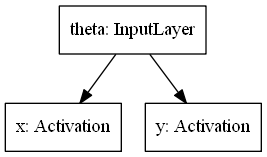

In [12]:
keras.utils.plot_model(math_p2c)

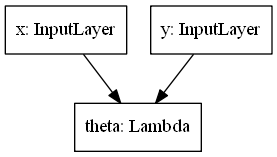

In [13]:
keras.utils.plot_model(math_c2p)

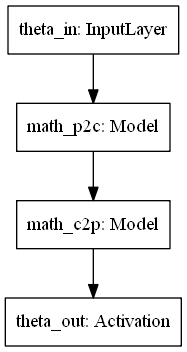

In [14]:
keras.utils.plot_model(math_p2p)

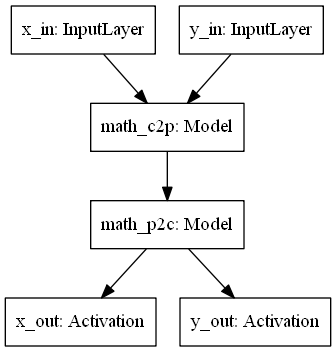

In [15]:
keras.utils.plot_model(math_c2c)

In [16]:
math_p2c.summary()

Model: "math_p2c"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x (Activation)                  (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
y (Activation)                  (None, 1)            0           theta[0][0]                      
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


In [17]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.MeanAbsoluteError()]

In [18]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [19]:
# Evaluate the p2c math model
# math_p2c.evaluate(theta, x)
math_p2c.evaluate(ds_p2c)

11/11 [==============================] - 0s 25ms/step - loss: 6.4332e-16 - x_loss: 3.3762e-16 - y_loss: 3.0570e-16 - x_mean_absolute_error: 7.4761e-09 - y_mean_absolute_error: 6.0690e-09


[6.433211191739163e-16,
 3.376231e-16,
 3.0569803e-16,
 7.476075e-09,
 6.0690017e-09]

In [20]:
# Evaluate the c2p math model
# math_c2p.evaluate(x, theta)
math_c2p.evaluate(ds_c2p)

11/11 [==============================] - 0s 17ms/step - loss: 0.0020 - mean_absolute_error: 3.4907e-04


[0.0019938595254328896, 0.00034907187]

In [21]:
# Evaluate the c2c math model
math_c2c.evaluate(ds_c2c)

11/11 [==============================] - 0s 40ms/step - loss: 2.2778e-15 - x_out_loss: 1.1606e-15 - y_out_loss: 1.1172e-15 - x_out_mean_absolute_error: 1.5851e-08 - y_out_mean_absolute_error: 1.3468e-08


[2.277801229709241e-15,
 1.1606123e-15,
 1.1171889e-15,
 1.5851123e-08,
 1.3467952e-08]

In [22]:
# Evaluate the p2p math model
math_p2p.evaluate(ds_p2p)

11/11 [==============================] - 0s 16ms/step - loss: 0.0020 - mean_absolute_error: 3.4907e-04


[0.001993859525432562, 0.00034906878]

In [ ]:
x_test = np.array([1.0])
y_test = np.array([0.0])

math_c2p.predict([y_test, x_test])

In [ ]:
np.pi/2

## Functions for visualizing neural network outputs $x = \cos(\theta)$

In [ ]:
def plot_pred_xy(model, theta):
    # Predictions of the model
    x_pred, y_pred = model.predict(theta)
    x_pred = x_pred.reshape((-1,))
    y_pred = y_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$x = \\cos(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$x$')
    ax.set_xlim(0.0, np.pi)
    ax.set_xticks(np.linspace(0.0, np.pi, 5))
    ax.set_xticklabels(['$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.set_ylim(-1.05, 1.05)
    ax.set_yticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(theta, x, color='blue', label='$\cos(\\theta)$', linewidth=4.0)
    ax.plot(theta, x_pred, color='red', label='NN$(\\theta)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [ ]:
def plot_error_xy(model, theta):
    # Predictions of the model
    x_pred = model.predict(theta)
    x_pred = x_pred.reshape((-1,))
    error = x_pred - np.cos(theta)
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error for $x = \\cos(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('error = $\cos(\\theta)$ - NN($\\theta$)')
    ax.set_xlim(0.0, np.pi)
    ax.set_xticks(np.linspace(0.0, np.pi, 5))
    ax.set_xticklabels(['$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(theta, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    # ax.legend()
    return fig, ax

## Neural networks for $x = \cos(\theta)$

### Network Design 0: [ ]
model_cos_ has only feature augmentation layers with even powers of theta

In [ ]:
def make_model_circle_p2c(powers, hidden_sizes, skip_layers):
    """
    Neural net model from theta to (x, y)
    INPUTS:
        powers: list of integer powers of the input in feature augmentation
        hidden_sizes: sizes of up to 2 hidden layers
        skip_layers: whether to include skip layers (copy of previous features)
    """
    # Input layer
    theta_in = keras.Input(shape=(1,), name='theta_in')

    # Number of hidden layers
    num_layers = len(hidden_sizes)

    # Feature augmentation; the selected powers
    theta_ps = []
    for p in powers:
        theta_p = keras.layers.Lambda(lambda z: tf.pow(z, p) / tf.exp(tf.math.lgamma(p+1.0)), name=f'theta_{p}')(theta_in)
        theta_ps.append(theta_p)
    
    # Augmented feature layer
    phi_0 = keras.layers.concatenate(inputs=theta_ps, name='phi_0')
    phi_n = phi_0

    # Dense feature layers
    
    # First hidden layer if applicable
    if num_layers > 0:
        phi_1 = keras.layers.Dense(units=hidden_sizes[0], activation='tanh', name='phi_1')(phi_0)
        if skip_layers:
            phi_1 = keras.layers.concatenate(inputs=[phi_0, phi_1], name='phi_1_aug')
        phi_n = phi_1

    # Second hidden layer if applicable
    if num_layers > 1:
        phi_2 = keras.layers.Dense(units=hidden_sizes[1], activation='tanh', name='phi_2')(phi_1)
        if skip_layers:
            phi_2 = keras.layers.concatenate(inputs=[phi_1, phi_2], name='phi_2_aug')
        phi_n = phi_2

    # Output layers
    x_out = keras.layers.Dense(units=1, name='x_out')(phi_n)
    y_out = keras.layers.Dense(units=1, name='y_out')(phi_n)

    # Wrap into a model
    model_name = f'model_circle_p2c_' + str(hidden_sizes)
    model = keras.Model(inputs=theta_in, outputs=[x_out, y_out], name=model_name) 
    return model

In [ ]:
# Build the NN model of y=cos(theta)
model_circle_p2c_ = make_model_circle_p2c(
    powers=[1,2,3,4,5,6,7,8],
    skip_layers=False,
    hidden_sizes=[])

model_circle_p2c_.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
keras.utils.plot_model(model_p2c_, show_shapes=False)

In [ ]:
model_circle_p2c_.summary()

In [ ]:
ds_p2c

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_circle_p2c_.load_weights('../models/polar/model_circle_[].h5')
    model_circle_p2c_.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_circle_p2c_ = vartbl['hist_circle_p2c_']
    print('Loaded model_circle_p2c_.')
except:
    hist = compile_and_fit(model=model_circle_p2c_, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_circle_p2c = hist.history
    vartbl['hist_circle_p2c'] = hist_circle_p2c
    save_vartbl(vartbl, fname)

In [ ]:
model_circle_p2c_.evaluate(ds_p2c)

In [ ]:
fig, ax = plot_loss_hist(model_circle_p2c_, 'Unit Circle $(x, y) = f(\theta)$: []')

In [ ]:
fig, ax = plot_pred_circle(model_cos_, theta)

In [ ]:
fig, ax = plot_error_cos(model_cos_, theta)

### Compare learned weights to those expected in power series expansion

In [ ]:
wts = np.zeros(5)
wts[0] = model_cos_.weights[1].numpy()
wts[1:5] = model_cos_.weights[0].numpy().flatten()
wts
print(f' p  : True   :  Learned :  Error')
for n in range(5):
    p = 2*n
    coef_true = (-1) ** (n)
    coef_learned = wts[n]
    coef_err = coef_learned - coef_true
    print(f'{p:2}   {coef_true:+6.4f}   {coef_learned:+6.4f}    {coef_err:+6.4f}')

### Network Design 1: [64]
(model_cos_64 has one layer with 64 hidden units)

In [ ]:
# Build the NN model of y=cos(theta)
model_cos_64 = make_model_pow(func_name='cos', 
                              input_name='theta',
                              output_name='x',
                              powers=[2,4,6,8],
                              skip_layers=True,
                              hidden_sizes=[64])

In [ ]:
keras.utils.plot_model(model_cos_64, show_shapes=False)

In [ ]:
model_cos_64.summary()

**Load the network and its loss history if available; otherwise train it**

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_cos_64.load_weights('../models/polar/model_cos_[64].h5')
    model_cos_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_cos_64 = vartbl['hist_cos_64']
    print('Loaded model_cos_64.')
except:
    hist = compile_and_fit(model=model_cos_64, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_cos_64 = hist.history
    vartbl['hist_cos_64'] = hist_cos_64
    save_vartbl(vartbl, fname)

In [ ]:
model_cos_64.evaluate(ds_p2c)

In [ ]:
fig, ax = plot_loss_hist(hist_cos_64, 'cos: [64]')

In [ ]:
fig, ax = plot_pred_cos(model_cos_64, theta)

In [ ]:
fig, ax = plot_error_cos(model_cos_64, theta)

### Network Design 2: [16, 16]
(model_cos_16_16 has two layers with 16 hidden units each)

In [ ]:
model_cos_16_16 = make_model_pow(func_name='cos', 
                              input_name='theta',
                              output_name='x',
                              powers=[2,4,6,8],
                              skip_layers=True,
                              hidden_sizes=[16, 16])

In [ ]:
keras.utils.plot_model(model_cos_16_16)

In [ ]:
model_cos_16_16.summary()

**Load the network and its loss history if available; otherwise train it**

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_cos_16_16.load_weights('../models/polar/model_cos_[16, 16].h5')
    model_cos_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_cos_16_16 = vartbl['hist_cos_16_16']
    print('Loaded model_cos_16_16.')
except:
    hist = compile_and_fit(model=model_cos_16_16, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_cos_16_16 = hist.history
    vartbl['hist_cos_16_16'] = hist_cos_16_16
    save_vartbl(vartbl, fname)

In [ ]:
model_cos_16_16.evaluate(ds_p2c)

In [ ]:
fig, ax = plot_loss_hist(hist_cos_16_16, 'cos: [16, 16]')

In [ ]:
fig, ax = plot_pred_cos(model_cos_16_16, theta)

In [ ]:
fig, ax = plot_error_cos(model_cos_16_16, theta)

## Neural networks for $\theta = \arccos(y)$

## Functions for visualizing neural network outputs $\theta = \arccos(y)$

In [ ]:
def plot_pred_arccos(model, x):
    # Predictions of the model
    theta_pred = model.predict(x)
    theta_pred = theta_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$\\theta = \\arccos(x)$ for {model.name}')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.set_ylim(0.0, np.pi)
    ax.set_yticks(np.linspace(0.0, np.pi, 5))
    ax.set_yticklabels(['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(x, theta, color='blue', label='$\\arccos(x)$', linewidth=4.0)
    ax.plot(x, theta_pred, color='red', label='NN$(x)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [ ]:
def plot_error_arccos(model, x):
    # Predictions of the model
    theta_pred = model.predict(x)
    theta_pred = theta_pred.reshape((-1,))
    error = theta - theta_pred
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error in $\\theta = \\arccos(x)$ for {model.name}')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(x, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

### Network Design 1: [64]

In [ ]:
model_arccos_64 = make_model_pow(func_name='arccos', 
                                 input_name = 'x',
                                 output_name='theta', 
                                 powers=[1,3,5,7],
                                 skip_layers=True,                                    
                                 hidden_sizes=[64])

In [ ]:
keras.utils.plot_model(model_arccos_64)

In [ ]:
model_arccos_64.summary()

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arccos_64.load_weights('../models/polar/model_arccos_[64].h5')
    model_arccos_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arccos_64 = vartbl['hist_arccos_64']
    print('Loaded model_arccos_64.')
except:
    hist = compile_and_fit(model=model_arccos_64, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arccos_64 = hist.history
    vartbl['hist_arccos_64'] = hist_arccos_64
    save_vartbl(vartbl, fname)

In [ ]:
model_arccos_64.evaluate(ds_c2p)

In [ ]:
fig, ax = plot_loss_hist(hist_arccos_64, 'arccos: [64]')

In [ ]:
fig, ax = plot_pred_arccos(model_arccos_64, x)

In [ ]:
fig, ax = plot_error_arccos(model_arccos_64, x)

### Network Design 2: [16, 16]

In [ ]:
model_arccos_16_16 = make_model_pow(func_name='arccos', 
                                    input_name = 'x',
                                    output_name='theta',
                                    powers=[1,3,5,7],
                                    skip_layers=True,                                    
                                    hidden_sizes=[16, 16])

In [ ]:
keras.utils.plot_model(model_arccos_16_16)

In [ ]:
model_arccos_16_16.summary()

In [ ]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arccos_16_16.load_weights('../models/polar/model_arccos_[16, 16].h5')
    model_arccos_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arccos_16_16 = vartbl['hist_arccos_16_16']
    print('Loaded model_arccos_16_16.')
except:
    hist = compile_and_fit(model=model_arccos_16_16, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arccos_16_16 = hist.history
    vartbl['hist_arccos_16_16'] = hist_arccos_16_16
    save_vartbl(vartbl, fname)

In [ ]:
model_arccos_16_16.evaluate(ds_c2p)

In [ ]:
fig, ax = plot_loss_hist(hist_arccos_16_16, 'arccos: [16, 16]')

In [ ]:
fig, ax = plot_pred_arccos(model_arccos_16_16, x)

In [ ]:
fig, ax = plot_error_arccos(model_arccos_16_16, x)

In [ ]:
# copies of model instances
model_cos = keras.models.clone_model(model_cos_16_16)
model_cos.set_weights(model_cos_16_16.get_weights())
model_arccos = keras.models.clone_model(model_arccos_16_16)
model_arccos.set_weights(model_arccos_16_16.get_weights())

# remove special characters from model names
# otherwise make_model_autoencoder fails with invalid scope name due to [16, 16] in model names
model_cos._name = 'model_cos'
model_arccos._name = 'model_arccos'

In [ ]:
model_p2p, model_c2c = make_model_autoencoder(
    model_p2c = model_cos,
    model_c2p = model_arccos)

In [ ]:
model_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_p2p.evaluate(ds_p2p)

In [ ]:
model_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_c2c.evaluate(ds_c2c)